# `Setup`

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from math import ceil
import gc

gc.collect()
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
        !git checkout -b sparse_filtering
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/alexanderries/aml_itu
MPS device found.


### `Config`

In [22]:
MODEL_NAME = 'TinyVGG_best'

# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## Sparse Filtring

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sparse Filter Class
class SparseFilter(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SparseFilter, self).__init__()
        self.weights = nn.Parameter(torch.randn(input_dim, output_dim) * 0.5)
        self.epsilon = 1e-8

    def soft_abs(self, value):
        return torch.sqrt(value ** 2 + self.epsilon)

    def forward(self, x):
        first = torch.matmul(x, self.weights)
        second = torch.abs(first)
        third = second / torch.sqrt(torch.sum(second ** 2, axis=0) + self.epsilon)
        return torch.sum(second)

# Training Sparse Filter
def train_sparse_filter(train_loader, input_dim, output_dim, lr=0.01, num_epochs=10):
    sparse_filter_model = SparseFilter(input_dim, output_dim)
    optimizer = optim.Adam(sparse_filter_model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 
    model = sparse_filter_model.to(device)
    for epoch in range(num_epochs):
        for data, _ in train_loader:
            # transform every image in batch to 168x224
            data = v2.Resize((168, 224))(data)

            # grayscale every image in batch
            data = v2.Grayscale(num_output_channels=1)(data)

            # dtype torch float
            data = data.type(torch.float)

            # normalize every image in batch
            data = v2.Normalize(mean=[0.485], std=[0.229])(data)

            # flatten every image in batch
            data_flattened = torch.flatten(data, start_dim=1)

            # dtype torch float
            data_flattened = data_flattened.type(torch.float)

            # to device
            data_flattened = data_flattened.to(device)
            
            optimizer.zero_grad()
            loss = sparse_filter_model(data_flattened)  # Forward pass on the batch
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
        scheduler.step() 

        print(f'Epoch {epoch}, Loss: {loss.item()}')
    return sparse_filter_model




In [24]:
import gc
gc.collect()

0

In [25]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assuming StateFarmDataset and SparseFilter are already defined
# Assuming config and target_transform are already set

# Load the dataset without transformations
train_data = StateFarmDataset(config, 
                              transform=None,  # No image transformations
                              split='train', 
                              target_transform=None,
                              apply_sparse_filtering=False)

# Create a DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Prepare data for sparse filtering (flatten the data)
# Note: Ensure that your dataset __getitem__ method returns the raw data without transformations
#flattened_data = []
#for data, _ in train_loader:
#    data = data.float()  # Convert data to float
#    data_flattened = data.reshape(-1).to(device)  # Move data to GPU
#    flattened_data.append(data_flattened) 

input_dim = 168*224 #flattened_data.shape[1] # [15646, 921600]
output_dim = 168*224  # Set the desired output dimension
sparse_filter_model = train_sparse_filter(train_loader, input_dim, output_dim)

/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (

RuntimeError: MPS backend out of memory (MPS allocated: 31.66 GB, other allocations: 314.18 MB, max allowed: 36.27 GB). Tried to allocate 5.28 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
#optimizer = optim.Adam(sparse_filter_model.parameters(), lr=0.01, weight_decay=1e-5)  # L2 regularization
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 
#for epoch in range(50):
#    for data, _ in train_loader:
#        data = data.float()  # Convert data to float
#        data_flattened = data.reshape(-1).to(device)  # Move data to GPU
#        
#        optimizer.zero_grad()
#        loss = sparse_filter_model(data_flattened)  # Forward pass on the batch
#        loss.backward()  # Compute gradients
#        optimizer.step()  # Update weights
#    scheduler.step() 

#    print(f'Epoch {epoch}, Loss: {loss.item()}')

In [ ]:
# Apply Sparse Filtering Transformation to Data
#with torch.no_grad():
#transformed_X = torch.matmul(X_flattened, model.weights).detach()

# Now you can use transformed_X as input to your TinyVGGish model or other models

# Note: Adjust input_dim, output_dim, and num_epochs according to your needs.

In [ ]:
# Save the model weights
torch.save(sparse_filter_model.state_dict(), './outputs/SparseFilterWeights/sparse_filter_model_try1.pth')

## `TinyVGG`

In [ ]:
# IMG Transformations
augmentations = {
    'train': v2.Compose([
    # v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop((168, 224), antialias=True, scale=(0.9, 1)),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize((168, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [ ]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='train', 
                              target_transform=target_transform,
                              apply_sparse_filtering=True)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=augmentations['val+test'], 
                            split='val', 
                            target_transform=target_transform,
                            apply_sparse_filtering=True)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform,
                            apply_sparse_filtering=True)

print(f'Lenght of val data: {len(test_data)}')

#### `Model`

In [ ]:
# TinyVGG inpsired
# First Convolution Blocks With BatchNorm, MaxPool and Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channesl, out_channls, kernel_size = (3, 3), stride=1, pool_kernel = (2,2), dropout_rate = .2):
        super(ConvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channesl,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channls),
            nn.Conv2d(in_channels=out_channls,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channls),
            nn.MaxPool2d(kernel_size = pool_kernel),
            nn.Dropout(dropout_rate))
    
    def forward(self, x):
        return self.main(x)

# Added couple extra fully connected layers
class FullyConnected(nn.Module):
    def __init__(self, in_features, out_featuers, dropout_rate) -> None:
        super(FullyConnected, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_featuers),
            nn.ReLU(True),
            nn.BatchNorm1d(out_featuers),
            nn.Dropout(dropout_rate),)
    
    def forward(self, x):
        return self.main(x)
    
    
class TinyVGGish(torch.nn.Module):
    def __init__(self, 
                 filters = 32, 
                 num_classes = 10,
                 kernel_size = 3, 
                 stride = 1, 
                 in_channels = 3,
                 pool_kernel_size = 2,
                 dense_dropout_rate = .25,
                 conv_dropout_rate = .25):
        
        """TinyVGG Inspired Model with Added complexity and Regularizaiton"""
        super(TinyVGGish, self).__init__()
        
        # First Convolution Block
        self.main = nn.Sequential(
            ConvBlock(in_channesl=in_channels, out_channls=filters, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=conv_dropout_rate),
            ConvBlock(in_channesl=filters, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=conv_dropout_rate),
            ConvBlock(in_channesl=filters*2, out_channls=filters*4, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=conv_dropout_rate),
            nn.Flatten(),
            FullyConnected(in_features=52224, out_featuers=512, dropout_rate=dense_dropout_rate),
            FullyConnected(in_features=512, out_featuers=128, dropout_rate=dense_dropout_rate),
            FullyConnected(in_features=128, out_featuers=num_classes, dropout_rate=dense_dropout_rate),
            )

    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.main(x)
        return x

In [ ]:
# Initialize Efficientnet model
model = TinyVGGish(num_classes = 10)

In [ ]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(batch_size)

32


In [ ]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

torch.Size([2])
torch.Size([2])
(2,)


ValueError: cannot reshape array of size 2 into shape (3,480,640)

#### `Training Methods`

In [ ]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [ ]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [ ]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [ ]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [ ]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Set model to train mode and do pass over data
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        print(f"Epoch {epoch+1} of {epochs} - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")

        # lr Scheduler step
        scheduler.step(val_loss)
        

        # Print info
        
            
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, MODEL_NAME, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, MODEL_NAME, epoch)
            visualize_training(history, epoch+1)
            break
    
    return history

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.9901e-03.
Adjusting learning rate of group 0 to 9.9606e-03.
Adjusting learning rate of group 0 to 9.9114e-03.
Adjusting learning rate of group 0 to 9.8429e-03.
Adjusting learning rate of group 0 to 9.7553e-03.
Adjusting learning rate of group 0 to 9.6489e-03.
Adjusting learning rate of group 0 to 9.5241e-03.
Adjusting learning rate of group 0 to 9.3815e-03.
Adjusting learning rate of group 0 to 9.2216e-03.
Adjusting learning rate of group 0 to 9.0451e-03.
Adjusting learning rate of group 0 to 8.8526e-03.
Adjusting learning rate of group 0 to 8.6448e-03.
Adjusting learning rate of group 0 to 8.4227e-03.
Adjusting learning rate of group 0 to 8.1871e-03.
Adjusting learning rate of group 0 to 7.9389e-03.
Adjusting learning rate of group 0 to 7.6791e-03.
Adjusting learning rate of group 0 to 7.4088e-03.
Adjusting learning rate of group 0 to 7.1289e-03.
Adjusting learning rate of group 0 to 6.8406e-03.


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


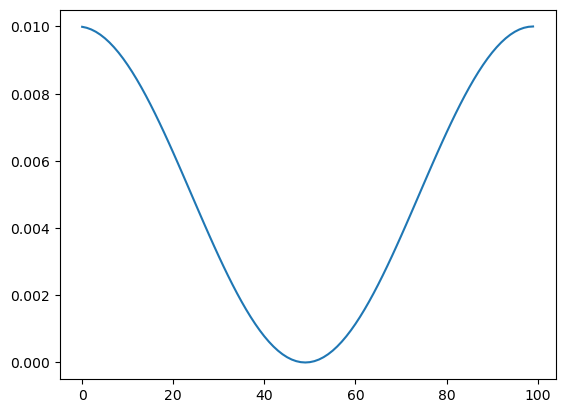

In [ ]:
# Setting seed and general training setup
torch.manual_seed(seed)
epcohs = 50
learming_rate = 0.01
momentum = .9
weight_decay = 1e-5
# nestrov = True

# Creating Model Object
model = TinyVGGish(num_classes = 10, dense_dropout_rate=.5).to(device)

# Optimizer and and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=learming_rate, weight_decay=weight_decay, momentum=momentum, nesterov=nestrov)
# optimizer = torch.optim.Adam(model.parameters(), lr=learming_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max = epochs,  
                                                       eta_min = 0,
                                                       verbose=1)

# Visualizing scheduler effect on learning rate
lrs = []
for i in range(100):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])
    
plt.plot(lrs)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Early stopping
early_stopping = EarlyStopper(patience=7, min_delta=.03)

##### `Training`

Epoch 1 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3.64: adjusting learning rate of group 0 to 9.8698e-03.
Epoch 1 of 50 - Train loss: 2.36349 - Train acc: 0.11735 - Val loss: 3.63983 - Val acc: 0.09940
Saving model with new best val_loss: 3.63983
Epoch 2 started...
Epoch 2.56: adjusting learning rate of group 0 to 9.9353e-03.
Epoch 2 of 50 - Train loss: 2.26367 - Train acc: 0.14675 - Val loss: 2.56287 - Val acc: 0.14907
Saving model with new best val_loss: 2.56287
Epoch 3 started...
Epoch 2.29: adjusting learning rate of group 0 to 9.9483e-03.
Epoch 3 of 50 - Train loss: 2.16294 - Train acc: 0.19704 - Val loss: 2.29094 - Val acc: 0.26303
Saving model with new best val_loss: 2.29094
Epoch 4 started...
Epoch 2.43: adjusting learning rate of group 0 to 9.9419e-03.
Epoch 4 of 50 - Train loss: 2.05385 - Train acc: 0.24130 - Val loss: 2.42899 - Val acc: 0.21448
Early Stopping Counter 1 of 7
Epoch 5 started...
Epoch 2.11: adjusting learning rate of group 0 to 9.9560e-03.
Epoch 5 of 50 - Train loss: 1.98415 - Train acc: 0.27240 - Val lo

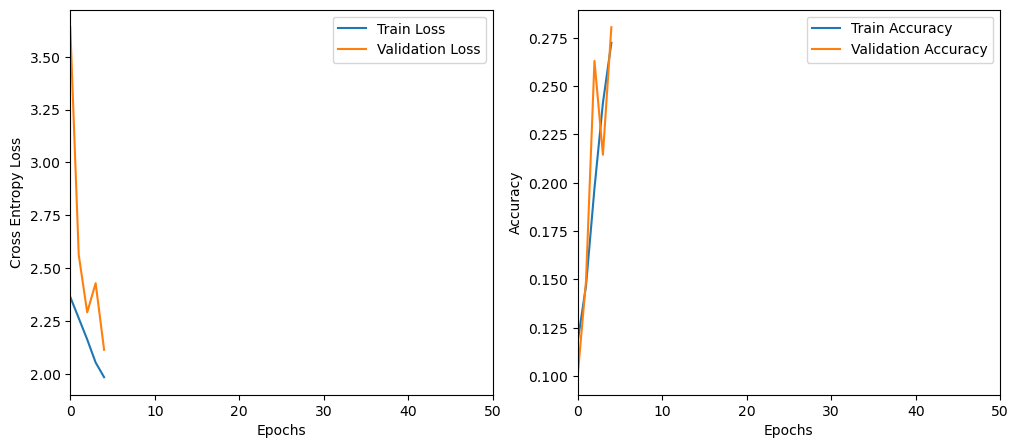

Early Stopping Counter Reset
Epoch 6 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.97: adjusting learning rate of group 0 to 9.9619e-03.
Epoch 6 of 50 - Train loss: 1.91004 - Train acc: 0.29713 - Val loss: 1.96569 - Val acc: 0.27750
Saving model with new best val_loss: 1.96569
Epoch 7 started...
Epoch 2.28: adjusting learning rate of group 0 to 9.9487e-03.
Epoch 7 of 50 - Train loss: 1.97657 - Train acc: 0.28262 - Val loss: 2.28145 - Val acc: 0.18654
Early Stopping Counter 1 of 7
Epoch 8 started...
Epoch 1.98: adjusting learning rate of group 0 to 9.9614e-03.
Epoch 8 of 50 - Train loss: 2.04239 - Train acc: 0.25872 - Val loss: 1.97856 - Val acc: 0.24153
Epoch 9 started...
Epoch 1.90: adjusting learning rate of group 0 to 9.9643e-03.
Epoch 9 of 50 - Train loss: 1.88188 - Train acc: 0.31338 - Val loss: 1.90399 - Val acc: 0.25039
Saving model with new best val_loss: 1.90399
Early Stopping Counter Reset
Epoch 10 started...
Epoch 1.83: adjusting learning rate of group 0 to 9.9669e-03.
Epoch 10 of 50 - Train loss: 1.81259 - Train acc: 0.34078 - Val loss: 1.83135 - 

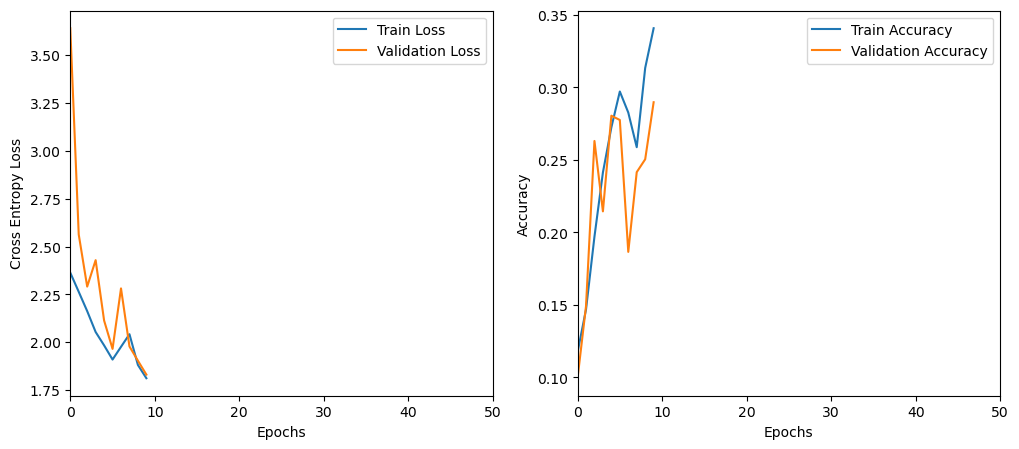

Epoch 11 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2.45: adjusting learning rate of group 0 to 9.9410e-03.
Epoch 11 of 50 - Train loss: 1.73837 - Train acc: 0.37372 - Val loss: 2.44728 - Val acc: 0.33514
Early Stopping Counter 1 of 7
Epoch 12 started...
Epoch 1.74: adjusting learning rate of group 0 to 9.9701e-03.
Epoch 12 of 50 - Train loss: 1.72051 - Train acc: 0.37800 - Val loss: 1.74039 - Val acc: 0.38867
Saving model with new best val_loss: 1.74039
Early Stopping Counter Reset
Epoch 13 started...
Epoch 1.68: adjusting learning rate of group 0 to 9.9722e-03.
Epoch 13 of 50 - Train loss: 1.64289 - Train acc: 0.40236 - Val loss: 1.68010 - Val acc: 0.40306
Saving model with new best val_loss: 1.68010
Epoch 14 started...
Epoch 1.57: adjusting learning rate of group 0 to 9.9757e-03.
Epoch 14 of 50 - Train loss: 1.58449 - Train acc: 0.42710 - Val loss: 1.57082 - Val acc: 0.43818
Saving model with new best val_loss: 1.57082
Epoch 15 started...
Epoch 1.51: adjusting learning rate of group 0 to 9.9775e-03.
Epoch 15 of 50 - Train loss:

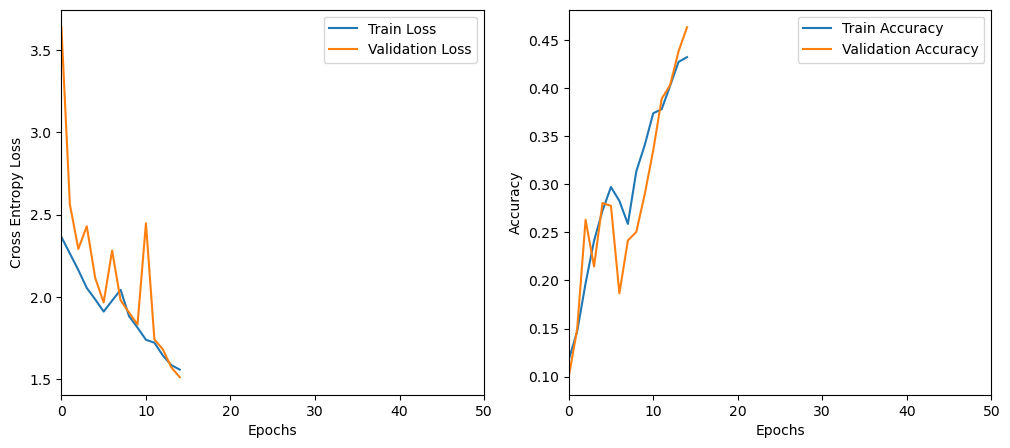

Epoch 16 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.51: adjusting learning rate of group 0 to 9.9774e-03.
Epoch 16 of 50 - Train loss: 1.49951 - Train acc: 0.44809 - Val loss: 1.51323 - Val acc: 0.46047
Epoch 17 started...
Epoch 1.58: adjusting learning rate of group 0 to 9.9755e-03.
Epoch 17 of 50 - Train loss: 1.47097 - Train acc: 0.46073 - Val loss: 1.57618 - Val acc: 0.44912
Early Stopping Counter 1 of 7
Epoch 18 started...
Epoch 1.50: adjusting learning rate of group 0 to 9.9777e-03.
Epoch 18 of 50 - Train loss: 1.44085 - Train acc: 0.46813 - Val loss: 1.50484 - Val acc: 0.45221
Saving model with new best val_loss: 1.50484
Early Stopping Counter Reset
Epoch 19 started...
Epoch 1.37: adjusting learning rate of group 0 to 9.9815e-03.
Epoch 19 of 50 - Train loss: 1.40468 - Train acc: 0.47725 - Val loss: 1.37052 - Val acc: 0.51966
Saving model with new best val_loss: 1.37052
Epoch 20 started...
Epoch 1.48: adjusting learning rate of group 0 to 9.9783e-03.
Epoch 20 of 50 - Train loss: 1.38676 - Train acc: 0.48409 - Val loss: 1.4

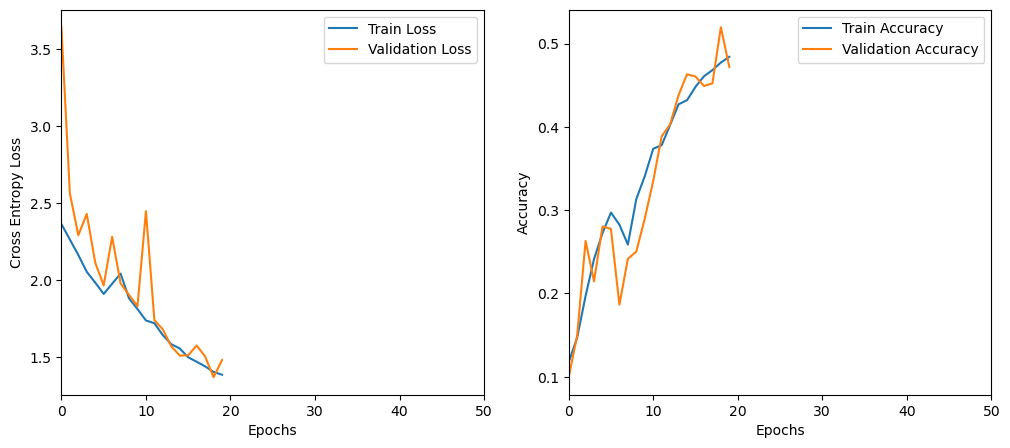

Early Stopping Counter 1 of 7
Epoch 21 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.46: adjusting learning rate of group 0 to 9.9789e-03.
Epoch 21 of 50 - Train loss: 1.34238 - Train acc: 0.49003 - Val loss: 1.46331 - Val acc: 0.45872
Early Stopping Counter 2 of 7
Epoch 22 started...
Epoch 1.36: adjusting learning rate of group 0 to 9.9818e-03.
Epoch 22 of 50 - Train loss: 1.36253 - Train acc: 0.49228 - Val loss: 1.35878 - Val acc: 0.53473
Saving model with new best val_loss: 1.35878
Early Stopping Counter Reset
Epoch 23 started...
Epoch 1.45: adjusting learning rate of group 0 to 9.9793e-03.
Epoch 23 of 50 - Train loss: 1.33750 - Train acc: 0.49478 - Val loss: 1.44814 - Val acc: 0.52733
Early Stopping Counter 1 of 7
Epoch 24 started...
Epoch 1.37: adjusting learning rate of group 0 to 9.9815e-03.
Epoch 24 of 50 - Train loss: 1.32164 - Train acc: 0.49764 - Val loss: 1.36889 - Val acc: 0.49998
Epoch 25 started...
Epoch 1.45: adjusting learning rate of group 0 to 9.9792e-03.
Epoch 25 of 50 - Train loss: 1.27446 - Train acc: 0.51258 - Val loss: 1.45354 - Val acc:

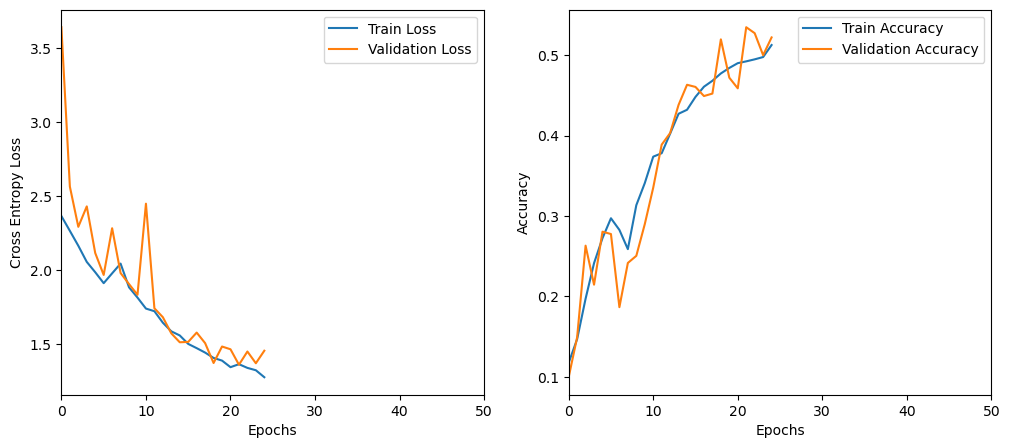

Early Stopping Counter 2 of 7
Epoch 26 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.38: adjusting learning rate of group 0 to 9.9811e-03.
Epoch 26 of 50 - Train loss: 1.26223 - Train acc: 0.51189 - Val loss: 1.38427 - Val acc: 0.49515
Epoch 27 started...
Epoch 1.32: adjusting learning rate of group 0 to 9.9827e-03.
Epoch 27 of 50 - Train loss: 1.24691 - Train acc: 0.51841 - Val loss: 1.32461 - Val acc: 0.56061
Saving model with new best val_loss: 1.32461
Early Stopping Counter Reset
Epoch 28 started...
Epoch 1.35: adjusting learning rate of group 0 to 9.9821e-03.
Epoch 28 of 50 - Train loss: 1.24206 - Train acc: 0.51841 - Val loss: 1.34850 - Val acc: 0.55438
Epoch 29 started...
Epoch 1.34: adjusting learning rate of group 0 to 9.9822e-03.
Epoch 29 of 50 - Train loss: 1.20472 - Train acc: 0.53220 - Val loss: 1.34437 - Val acc: 0.55966
Epoch 30 started...
Epoch 1.44: adjusting learning rate of group 0 to 9.9796e-03.
Epoch 30 of 50 - Train loss: 1.21870 - Train acc: 0.52474 - Val loss: 1.43843 - Val acc: 0.47152


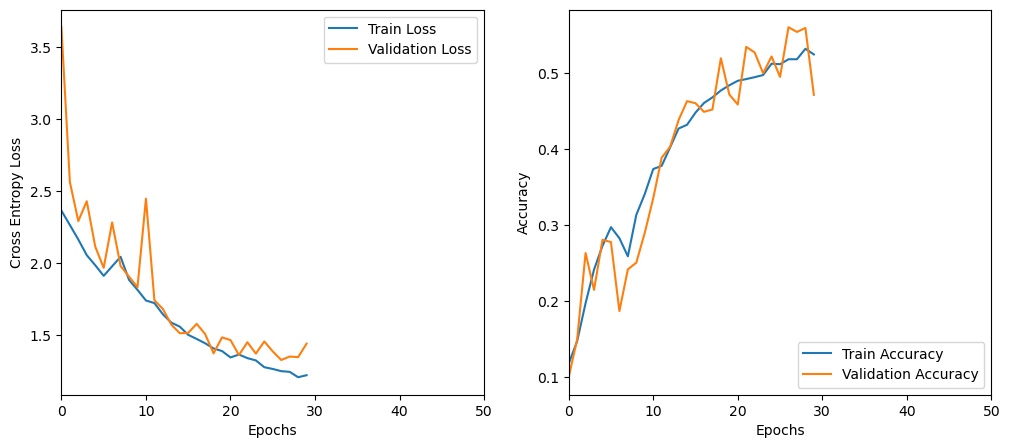

Early Stopping Counter 1 of 7
Epoch 31 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.58: adjusting learning rate of group 0 to 9.9753e-03.
Epoch 31 of 50 - Train loss: 1.20578 - Train acc: 0.53113 - Val loss: 1.58171 - Val acc: 0.50607
Early Stopping Counter 2 of 7
Epoch 32 started...
Epoch 1.38: adjusting learning rate of group 0 to 9.9812e-03.
Epoch 32 of 50 - Train loss: 1.20015 - Train acc: 0.52845 - Val loss: 1.38059 - Val acc: 0.51371
Early Stopping Counter 3 of 7
Epoch 33 started...
Epoch 1.32: adjusting learning rate of group 0 to 9.9829e-03.
Epoch 33 of 50 - Train loss: 1.16495 - Train acc: 0.53700 - Val loss: 1.31598 - Val acc: 0.54261
Saving model with new best val_loss: 1.31598
Early Stopping Counter Reset
Epoch 34 started...
Epoch 1.36: adjusting learning rate of group 0 to 9.9818e-03.
Epoch 34 of 50 - Train loss: 1.15827 - Train acc: 0.54237 - Val loss: 1.35834 - Val acc: 0.50375
Early Stopping Counter 1 of 7
Epoch 35 started...
Epoch 1.19: adjusting learning rate of group 0 to 9.9859e-03.
Epoch 35 of 50 - Train loss: 1.13448 - Train acc: 0.54896 

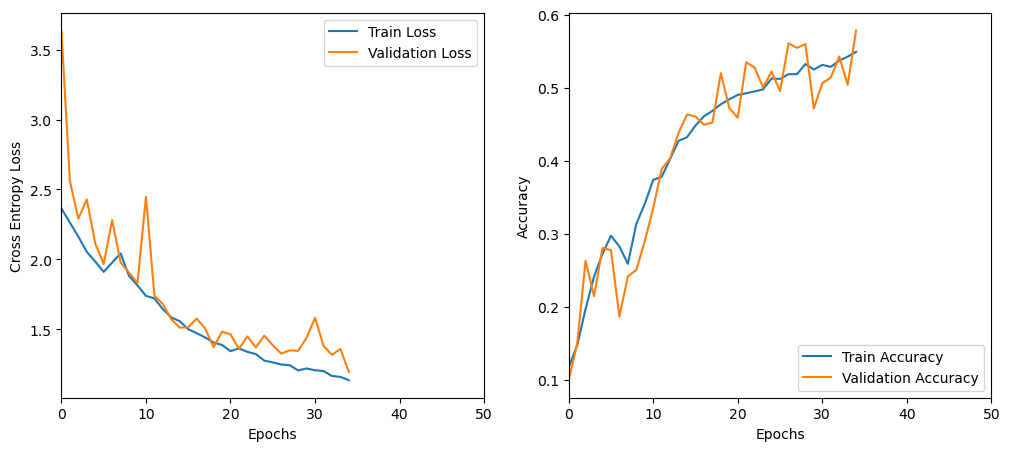

Early Stopping Counter Reset
Epoch 36 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.46: adjusting learning rate of group 0 to 9.9791e-03.
Epoch 36 of 50 - Train loss: 1.12214 - Train acc: 0.54576 - Val loss: 1.45720 - Val acc: 0.47945
Early Stopping Counter 1 of 7
Epoch 37 started...
Epoch 1.39: adjusting learning rate of group 0 to 9.9810e-03.
Epoch 37 of 50 - Train loss: 1.15947 - Train acc: 0.53981 - Val loss: 1.38698 - Val acc: 0.51457
Early Stopping Counter 2 of 7
Epoch 38 started...
Epoch 1.36: adjusting learning rate of group 0 to 9.9818e-03.
Epoch 38 of 50 - Train loss: 1.13727 - Train acc: 0.54442 - Val loss: 1.35822 - Val acc: 0.54049
Early Stopping Counter 3 of 7
Epoch 39 started...
Epoch 1.23: adjusting learning rate of group 0 to 9.9851e-03.
Epoch 39 of 50 - Train loss: 1.13698 - Train acc: 0.54914 - Val loss: 1.23036 - Val acc: 0.58685
Early Stopping Counter 4 of 7
Epoch 40 started...
Epoch 1.09: adjusting learning rate of group 0 to 9.9883e-03.
Epoch 40 of 50 - Train loss: 1.10940 - Train acc: 0.55167 - Val loss: 1.09115 - Val acc: 0.62521
Savin

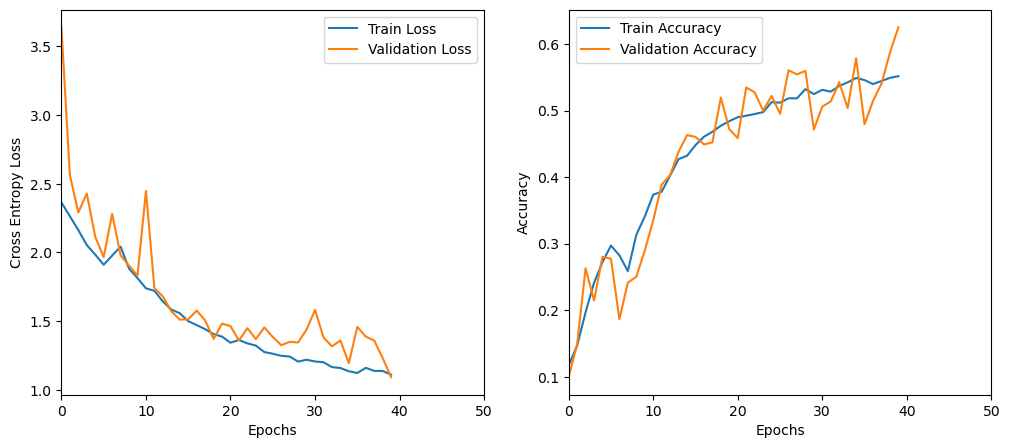

Early Stopping Counter Reset
Epoch 41 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.23: adjusting learning rate of group 0 to 9.9851e-03.
Epoch 41 of 50 - Train loss: 1.10903 - Train acc: 0.55738 - Val loss: 1.22754 - Val acc: 0.56933
Early Stopping Counter 1 of 7
Epoch 42 started...
Epoch 1.16: adjusting learning rate of group 0 to 9.9868e-03.
Epoch 42 of 50 - Train loss: 1.11345 - Train acc: 0.55165 - Val loss: 1.15834 - Val acc: 0.61688
Early Stopping Counter 2 of 7
Epoch 43 started...
Epoch 1.22: adjusting learning rate of group 0 to 9.9852e-03.
Epoch 43 of 50 - Train loss: 1.10503 - Train acc: 0.54955 - Val loss: 1.22403 - Val acc: 0.57952
Early Stopping Counter 3 of 7
Epoch 44 started...
Epoch 1.15: adjusting learning rate of group 0 to 9.9870e-03.
Epoch 44 of 50 - Train loss: 1.08973 - Train acc: 0.55598 - Val loss: 1.14923 - Val acc: 0.60375
Early Stopping Counter 4 of 7
Epoch 45 started...
Epoch 1.36: adjusting learning rate of group 0 to 9.9816e-03.
Epoch 45 of 50 - Train loss: 1.20570 - Train acc: 0.52932 - Val loss: 1.36411 - Val acc: 0.54548


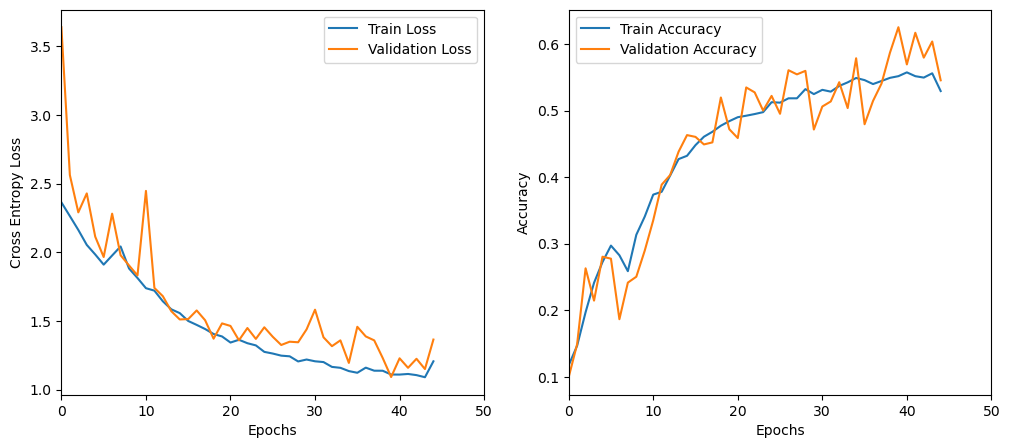

Early Stopping Counter 5 of 7
Epoch 46 started...


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1.26: adjusting learning rate of group 0 to 9.9844e-03.
Epoch 46 of 50 - Train loss: 1.15904 - Train acc: 0.53987 - Val loss: 1.25841 - Val acc: 0.58424
Early Stopping Counter 6 of 7
Epoch 47 started...
Epoch 1.39: adjusting learning rate of group 0 to 9.9809e-03.
Epoch 47 of 50 - Train loss: 1.13664 - Train acc: 0.54140 - Val loss: 1.39035 - Val acc: 0.54247
Early Stopping Counter 7 of 7
Epoch 47 of 50 - Early stopping
Saving final model, with loss:  1.390347299121675


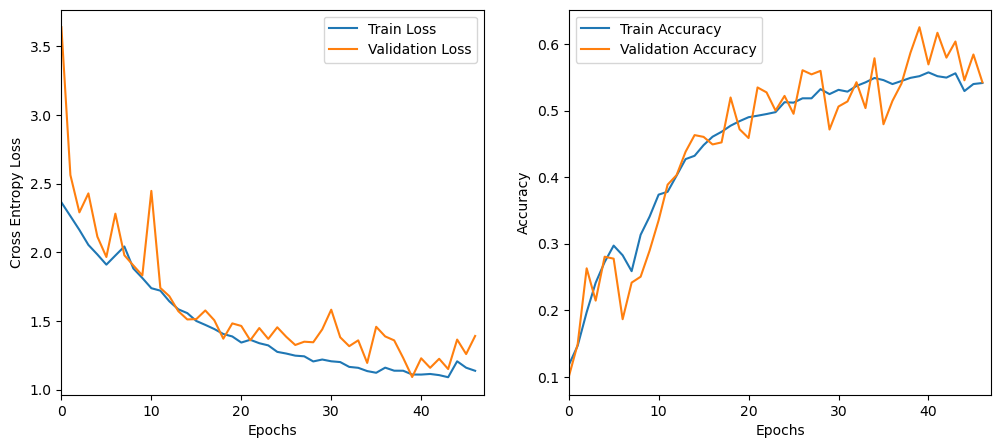

In [ ]:
# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler,
                early_stopping=early_stopping)

### Testing on Test Images

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

test_imgs = os.listdir(config['dataset']['images']['test'])
test_img = test_imgs[random.randint(0, len(test_imgs))]

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
for i, data in enumerate(test_dataloader):
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Forward pass
    prediction = model(imgs)
    
    break

In [ ]:
prediction.argmax(1)[0].item()

3

Prediction: talking on the phone - left
True: talking on the phone - left


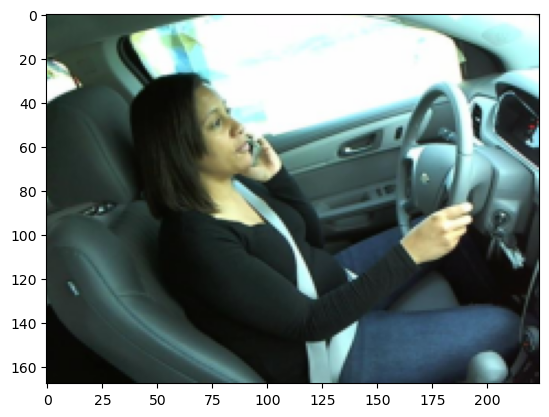

In [ ]:
index = 16
print('Prediction:', config['dataset']['class_mapping']['c' + str(prediction.argmax(1)[index].item())])
print('True:', config['dataset']['class_mapping']['c' + str(labels[index].item())])

plt.imshow(imgs[index].cpu().permute(1, 2, 0))